<a href="https://colab.research.google.com/github/dbtmddn41/deep_learning/blob/main/practice/deepdream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

97963/97963 [==============================] - 0s 0us/step


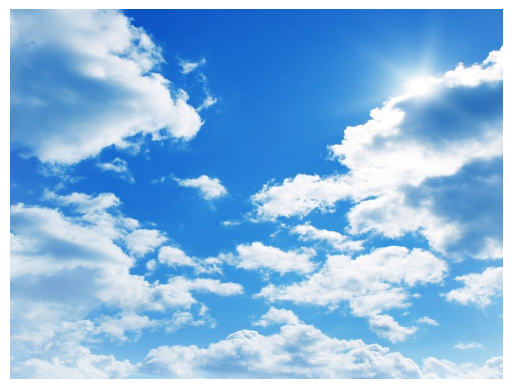

In [ ]:
url = 'https://mblogthumb-phinf.pstatic.net/MjAxODAxMjJfMjky/MDAxNTE2NjE0NzU2ODg5.duutEoMloJLovgU1Mg3Y5h75dZs06WbMDbX1tyfwVCwg.4gKK_AEt4X3vBtysot9Ps-5D1FVm7BfcOFqlq0UEUS0g.JPEG.designmaeg/sky_001.jpg?type=w800'
base_img_path = keras.utils.get_file("sky2.jpg", origin=url)
plt.axis('off')
plt.imshow(keras.utils.load_img(base_img_path))

In [ ]:
from tensorflow.keras.applications import inception_v3

model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

In [ ]:
print([layer.name for layer in model.layers])

['input_5', 'conv2d_376', 'batch_normalization_376', 'activation_376', 'conv2d_377', 'batch_normalization_377', 'activation_377', 'conv2d_378', 'batch_normalization_378', 'activation_378', 'max_pooling2d_16', 'conv2d_379', 'batch_normalization_379', 'activation_379', 'conv2d_380', 'batch_normalization_380', 'activation_380', 'max_pooling2d_17', 'conv2d_384', 'batch_normalization_384', 'activation_384', 'conv2d_382', 'conv2d_385', 'batch_normalization_382', 'batch_normalization_385', 'activation_382', 'activation_385', 'average_pooling2d_36', 'conv2d_381', 'conv2d_383', 'conv2d_386', 'conv2d_387', 'batch_normalization_381', 'batch_normalization_383', 'batch_normalization_386', 'batch_normalization_387', 'activation_381', 'activation_383', 'activation_386', 'activation_387', 'mixed0', 'conv2d_391', 'batch_normalization_391', 'activation_391', 'conv2d_389', 'conv2d_392', 'batch_normalization_389', 'batch_normalization_392', 'activation_389', 'activation_392', 'average_pooling2d_37', 'conv

In [ ]:
layer_settings = {'mixed9': 0.3, 'mixed10': 2.0}
outputs_dict = dict([(layer.name, layer.output) for layer in (model.get_layer(name) for name in layer_settings.keys())])
feature_extractor = keras.Model(model.inputs, outputs_dict)

In [ ]:
def compute_loss(input_img):
    features = feature_extractor(input_img)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads) #그래디언트 정규화 트릭
    img += learning_rate * grads
    return loss, img

def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        print(f"...스텝{i} loss: {loss}")
        if max_loss is not None and loss > max_loss:
            break
    return img

In [ ]:
step = 15   #높이면 선명해짐
num_octave = 5  #높이면 화질 좋아짐
octave_scale = 1.3
iterations = 100
max_loss = 30.  #높이면 복잡해짐

In [ ]:
import numpy as np

def preprocess_image(img_path):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img += 1.0
    img *= 127.5
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [ ]:
origin_img = preprocess_image(base_img_path)
# origin_img = tf.image.resize(origin_img, (400,400))
origin_shape = origin_img.shape[1:3]

successive_shapes = [origin_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale**i)) for dim in origin_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(origin_img, successive_shapes[0])
img = tf.identity(origin_img)
for i, shape in enumerate(successive_shapes):
    print(f'{shape} 크기의 {i}번째 옥타브 처리')
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    upscaled_shrunk_origin_img = tf.image.resize(shrunk_original_img, shape)
    same_size_origin = tf.image.resize(origin_img, shape)
    lost_detail = same_size_origin - upscaled_shrunk_origin_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(origin_img, shape)

keras.utils.save_img("deep_dream.png", deprocess_image(img.numpy()))

(210, 280) 크기의 0번째 옥타브 처리
...스텝0 loss: 0.9241414070129395
...스텝1 loss: 3.4121253490448
...스텝2 loss: 12.330215454101562
...스텝3 loss: 5.130107402801514
...스텝4 loss: 10.733683586120605
...스텝5 loss: 10.807150840759277
...스텝6 loss: 8.965713500976562
...스텝7 loss: 19.85974884033203
...스텝8 loss: 17.09783172607422
...스텝9 loss: 19.22715950012207
...스텝10 loss: 14.491425514221191
...스텝11 loss: 20.642324447631836
...스텝12 loss: 22.148040771484375
...스텝13 loss: 27.409259796142578
...스텝14 loss: 27.102577209472656
...스텝15 loss: 29.594327926635742
...스텝16 loss: 18.030303955078125
...스텝17 loss: 39.92588424682617
(273, 364) 크기의 1번째 옥타브 처리
...스텝0 loss: 6.04491662979126
...스텝1 loss: 9.632160186767578
...스텝2 loss: 10.496912956237793
...스텝3 loss: 10.080833435058594
...스텝4 loss: 9.04594898223877
...스텝5 loss: 9.17642593383789
...스텝6 loss: 8.710983276367188
...스텝7 loss: 9.607719421386719
...스텝8 loss: 9.98936939239502
...스텝9 loss: 12.380880355834961
...스텝10 loss: 16.100122451782227
...스텝11 loss: 17.73386955261230

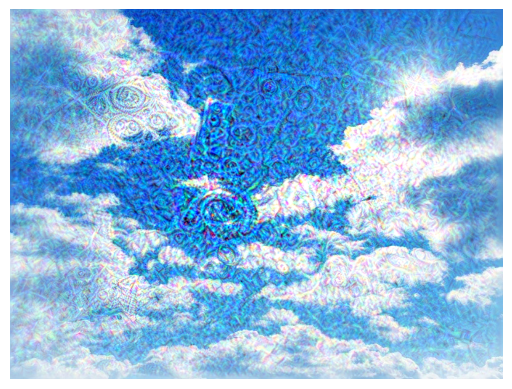

In [ ]:
plt.axis('off')
plt.imshow(keras.utils.load_img("deep_dream.png"))